In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
from numpy import exp
from scipy import ndimage
from func import *
from astropy.table import Table, hstack
import os
import glob
from astropy.table import Table, vstack, join
import pandas as pd
from shutil import copyfile
from scipy.optimize import leastsq
import math
from astropy.convolution import Gaussian2DKernel
from scipy.signal import convolve as scipy_convolve
from astropy.convolution import convolve

In [2]:
def flux_data_err(obj,destination_path_cube="/home/mainak/Downloads/Outflow_paper1/MUSE"):
    hdu = fits.open('%s/Flux Maps/%s/subcube_par_%s.fits'%(destination_path_cube,obj,obj))
    (OIII_nr,OIII_br,Hb1_blr_br,Hb2_blr_br) = (hdu[2].data,hdu[3].data,hdu[5].data,hdu[6].data)
    hdu.close()
    
    hdu = fits.open('%s/Flux Maps/%s/subcube_par_err_%s.fits'%(destination_path_cube,obj,obj))
    (OIII_nr_err,OIII_br_err,Hb1_blr_br_err,Hb2_blr_br_err) = (hdu[2].data,hdu[3].data,hdu[5].data,hdu[6].data)
    hdu.close()
    
    hdu = fits.open('%s/%s/%s_9_arcsec_empirical_factor_subcube.fits'%(destination_path_cube,obj,obj))
    central_tab = hdu[1].data
    central_columns = hdu[1].header
    (emp_Hb1,emp_Hb2,emp_wing) = (central_tab.field('emp_fact_Hb1')[0],central_tab.field('emp_fact_Hb2')[0],central_tab.field('emp_fact_wing')[0])
    hdu.close()
    
    (amp_OIII_nr,amp_OIII_br,amp_Hb1_blr_br,amp_Hb2_blr_br) = (np.max(OIII_nr),np.max(OIII_br),np.max(Hb1_blr_br),np.max(Hb2_blr_br))
    if amp_Hb1_blr_br > amp_Hb2_blr_br:
        (Hb_blr_br,amp_Hb_blr_br,Hb_blr_err,emp_Hb_blr) = (Hb1_blr_br,amp_Hb1_blr_br,Hb1_blr_br_err,emp_Hb1)
    else:
        (Hb_blr_br,amp_Hb_blr_br,Hb_blr_err,emp_Hb_blr) = (Hb2_blr_br,amp_Hb2_blr_br,Hb2_blr_br_err,emp_Hb2)
    print (emp_Hb_blr)
    (blr_err_final,wing_err_final,core_err_final) = (emp_Hb_blr*Hb_blr_err,emp_wing*OIII_br_err,OIII_nr_err)
    return Hb_blr_br,OIII_br,OIII_nr,amp_Hb_blr_br,amp_OIII_br,amp_OIII_nr,blr_err_final,wing_err_final,core_err_final
    

In [3]:
def ellip_moffat2D(p,xy,data,error):
    xy=(x,y)
    [amp, x0, y0, A, B, C, alpha] = p 
    g = amp*((1.0+A*(x-x0)**2+B*(y-y0)**2+C*(x-x0)*(y-y0))**(-alpha))
    h = (data - g)/error
    return h.ravel()

def ellip_moffat2D_fixkin(p,xy,data,error,fixed_param):
    [A,B,C,alpha] = fixed_param
    xy=(x,y)
    [amp, x0, y0] = p    
    g = amp*((1.0+A*(x-x0)**2+B*(y-y0)**2+C*(x-x0)*(y-y0))**(-alpha))
    h = (data - g)/error
    return h.ravel()

In [4]:
def elliptical_moffat_fit(data,error,box_size,amp,x0,y0,fix_par,MC_loops=100):
    y, x = np.mgrid[:box_size, :box_size]
    xy=(x,y)
    
    if fix_par is None:
        p= [amp,x0,y0,0.25,0.25,-0.008,3]
        popt,pcov = leastsq(ellip_moffat2D,x0=p,args=(xy,data,error),maxfev = 10000000)
        [amp_out,x0_out,y0_out,A_out,B_out,C_out,alpha_out]= popt
        theta_out = 0.5*np.arctan(C_out/(A_out - B_out))
        a_out = np.sqrt(2/(A_out + B_out + np.sqrt(C_out**2 +(A_out - B_out)**2)))
        b_out = np.sqrt(2/(A_out + B_out - np.sqrt(C_out**2 +(A_out - B_out)**2)))
        [fwhm1_out,fwhm2_out] = [2*a_out*np.sqrt(2**(1/alpha_out)-1),2*b_out*np.sqrt(2**(1/alpha_out)-1)]
        par = [amp_out,x0_out,y0_out,A_out,B_out,C_out,alpha_out,a_out,b_out,theta_out,fwhm1_out,fwhm2_out]
        mod_rav = data.ravel() - ellip_moffat2D(popt,xy,data,error)*error.ravel()
    else:
        p= [amp,x0,y0]
        popt,pcov = leastsq(ellip_moffat2D_fixkin,x0=p,args=(xy,data,error,fix_par),maxfev = 10000000)
        [amp_out,x0_out,y0_out]= popt
        par = popt
        mod_rav = data.ravel() - ellip_moffat2D_fixkin(popt,xy,data,error,fix_par)*error.ravel()
    model = mod_rav.reshape(box_size,box_size)
    residual = data-model
    res = (residual/error)

    parameters_MC = np.zeros((len(par),MC_loops))
    for l in range(MC_loops):
        iteration_data = np.random.normal(data,error) 
        if fix_par is None:
            p= [amp,x0,y0,0.25,0.25,-0.008,3]
            popt_MC,pcov_MC = leastsq(ellip_moffat2D,x0=p,args=(xy,iteration_data,error),maxfev = 10000000)
            [amp_MC,x0_MC,y0_MC,A_MC,B_MC,C_MC,alpha_MC]= popt_MC
            theta_MC = 0.5*np.arctan(C_MC/(A_MC - B_MC))
            a_MC = np.sqrt(2/(A_MC + B_MC + np.sqrt(C_MC**2 +(A_MC - B_MC)**2)))
            b_MC = np.sqrt(2/(A_MC + B_MC - np.sqrt(C_MC**2 +(A_MC - B_MC)**2)))
            [fwhm1_MC,fwhm2_MC] = [2*a_MC*np.sqrt(2**(1/alpha_MC)-1),2*b_MC*np.sqrt(2**(1/alpha_MC)-1)]
            par_MC = [amp_MC,x0_MC,y0_MC,A_MC,B_MC,C_MC,alpha_MC,a_MC,b_MC,theta_MC,fwhm1_MC,fwhm2_MC]   
            parameters_MC[:,l] = par_MC    
        else:
            p= [amp,x0,y0]
            popt_MC,pcov_MC = leastsq(ellip_moffat2D_fixkin,x0=p,args=(xy,iteration_data,error,fix_par),maxfev = 10000000)
            [amp_MC,x0_out,y0_out]= popt_MC
            parameters_MC[:,l] = popt_MC    
    parameters_err = np.std(parameters_MC,1) 
    return par,parameters_err,model,res

In [5]:
def chi_squared(data,model,err):
    res = data - model
    a = np.sum((res/err)**2)
    return a

def red_chi_squared(data,model,err,n_free):
    dof = len(data.flatten()) - n_free
    res = data - model
    k = res/err
    k[k>10**10]=0
    l = k[k!=0]
    a = np.sum(l**2)
    red = a/dof
    return red


In [6]:
def moffat_table(full_data,full_error,obj,destination_path_cube="/home/mainak/Downloads/Outflow_paper1/MUSE"):
    column_names={'amp_Hb_blr':0,'x0_Hb_Blr':1,'y0_Hb_Blr':2,'A':3,'B':4,'C':5,'alpha':6,'a':7,'b':8,'theta':9,'fwhm1':10,'fwhm2':11,'amp_OIII_br':12,'x0_OIII_br':13,'y0_OIII_br':14,'amp_OIII_nr':15,'x0_OIII_nr':16,'y0_OIII_nr':17}
    columns=[]
    for key in column_names.keys():
        columns.append(fits.Column(name=key,format='E',array=[full_data[column_names[key]]]))
        columns.append(fits.Column(name=key+'_err',format='E',array=[full_error[column_names[key]]]))
    coldefs = fits.ColDefs(columns)
    hdu = fits.BinTableHDU.from_columns(coldefs)
    hdu.writeto('%s/%s/3_arcsec_moffat_table_%s.fits'%(destination_path_cube,obj,obj),overwrite=True)

def maps(Hb_blr_br_data,OIII_br_data,OIII_nr_data,Hb_model,OIII_br_model,OIII_nr_model,Hb_res,OIII_br_res,OIII_nr_res,obj,destination_path_cube="/home/mainak/Downloads/Outflow_paper1/MUSE"):
    hdus=[]
    hdus.append(fits.PrimaryHDU())
    hdus.append(fits.ImageHDU(Hb_blr_br_data,name='Hb_blr_br_data'))
    hdus.append(fits.ImageHDU(OIII_br_data,name='OIII_br_data'))
    hdus.append(fits.ImageHDU(OIII_nr_data,name='OIII_nr_data'))
    hdus.append(fits.ImageHDU(Hb_model,name='Hb_blr_br_model'))
    hdus.append(fits.ImageHDU(OIII_br_model,name='OIII_br_model'))   
    hdus.append(fits.ImageHDU(OIII_nr_model,name='OIII_nr_model'))
    hdus.append(fits.ImageHDU(Hb_res,name='Hb_blr_br_res'))
    hdus.append(fits.ImageHDU(OIII_br_res,name='OIII_br_res'))
    hdus.append(fits.ImageHDU(OIII_nr_res,name='OIII_nr_res'))
    hdu = fits.HDUList(hdus)
    hdu.writeto('%s/%s/3_arcsec_maps_%s.fits'%(destination_path_cube,obj,obj),overwrite='True')

def fluxden_compare(obj,Hb_blr_br_data,OIII_br_data,Hb_model,OIII_br_model,Hb_blr_br_err,OIII_br_err,destination_path_cube="/home/mainak/Downloads/Outflow_paper1/MUSE"):
    f_blr_data = np.sum(Hb_blr_br_data)
    f_wing_data = np.sum(OIII_br_data)
    f_blr_model = np.sum(Hb_model)
    f_wing_model = np.sum(OIII_br_model)
    f_blr_err = np.sqrt(np.sum(Hb_blr_br_err**2))
    f_wing_err = np.sqrt(np.sum(OIII_br_err**2))
    tab_par = [f_blr_data,f_wing_data,f_blr_model,f_wing_model]
    tab_err = [f_blr_err,f_wing_err,0,0]
    column_names={'flux_blr_data':0,'flux_wing_data':1,'flux_blr_model':2,'flux_wing_model':3}
    columns=[]
    for key in column_names.keys():
        columns.append(fits.Column(name=key,format='E',array=[tab_par[column_names[key]]]))
        columns.append(fits.Column(name=key+'_err',format='E',array=[tab_err[column_names[key]]]))
    coldefs = fits.ColDefs(columns)
    hdu = fits.BinTableHDU.from_columns(coldefs)
    hdu.writeto('%s/%s/%s_3_arcsec_fluxden_HbOIII.fits'%(destination_path_cube,obj,obj),overwrite=True)
    
def fluxden_comp_table(obj,destination_path_cube="/home/mainak/Downloads/Outflow_paper1/MUSE"):
    t1 = Table.read('%s/%s/source_%s.fits'%(destination_path_cube,obj,obj),format='fits')
    t2 = Table.read('%s/%s/%s_3_arcsec_fluxden_HbOIII.fits'%(destination_path_cube,obj,obj),format='fits')
    new = hstack([t1, t2])
    new.write('%s/%s/%s_3_arcsec_fluxden_HbOIII.fits'%(destination_path_cube,obj,obj),overwrite=True)
    
def emp_table(obj,emp_blr,emp_wing,destination_path_cube="/home/mainak/Downloads/Outflow_paper1/MUSE"):
    popt = [emp_blr,emp_wing]
    column_names={'emp_fact_blr':0,'emp_fact_wing':1}
    columns=[]
    for key in column_names.keys():
        columns.append(fits.Column(name=key,format='E',array=[popt[column_names[key]]]))
    coldefs = fits.ColDefs(columns)
    hdu = fits.BinTableHDU.from_columns(coldefs)
    hdu.writeto('%s/%s/%s_3_arcsec_scaling_subcube.fits'%(destination_path_cube,obj,obj),overwrite=True)

def emp_fact_table(obj,destination_path_cube="/home/mainak/Downloads/Outflow_paper1/MUSE"):
    t1 = Table.read('%s/%s/source_%s.fits'%(destination_path_cube,obj,obj),format='fits')
    t2 = Table.read('%s/%s/%s_9_arcsec_scaling_subcube.fits'%(destination_path_cube,obj,obj),format='fits')
    new = hstack([t1, t2])
    new.write('%s/%s/%s_9_arcsec_scaling_subcube.fits'%(destination_path_cube,obj,obj),overwrite=True)

In [8]:
def algorithm_script(obj,z,destination_path_cube="/home/mainak/Downloads/Outflow_paper1/MUSE"):  
    print ('%s'%(obj))
    (Hb_blr_br_data,OIII_br_data,OIII_nr_data,amp_Hb_blr_br,amp_OIII_br,amp_OIII_nr,Hb_blr_br_err,OIII_br_err,OIII_nr_err) = flux_data_err(obj)
    box_size = np.shape(Hb_blr_br_data)[0]
    (brightest_pixel_Hb_blr_br_x,brightest_pixel_Hb_blr_br_y,brightest_pixel_OIII_br_x,brightest_pixel_OIII_br_y,brightest_pixel_OIII_nr_x,brightest_pixel_OIII_nr_y) = brightest_pixel_flux_map(Hb_blr_br_data,OIII_br_data,OIII_nr_data) 
    print (brightest_pixel_OIII_nr_x,brightest_pixel_OIII_nr_y)
    
    (Hb_par,Hb_error,Hb_model,Hb_res) = elliptical_moffat_fit(Hb_blr_br_data,Hb_blr_br_err,box_size,amp_Hb_blr_br,brightest_pixel_Hb_blr_br_x,brightest_pixel_Hb_blr_br_y,None,100)
    print (Hb_par,Hb_error)
    red_chi_sq_Hb = red_chi_squared(Hb_blr_br_data,Hb_model,Hb_blr_br_err,5)   
    #print (red_chi_sq_Hb)
    fixed_param = [Hb_par[3],Hb_par[4],Hb_par[5],Hb_par[6]]
    (OIII_br_par,OIII_br_error,OIII_br_model,OIII_br_res) = elliptical_moffat_fit(OIII_br_data,OIII_br_err,box_size,amp_OIII_br,brightest_pixel_OIII_br_x,brightest_pixel_OIII_br_y,fixed_param,100)   
    print (OIII_br_par,OIII_br_error)
    (OIII_nr_par,OIII_nr_error,OIII_nr_model,OIII_nr_res) = elliptical_moffat_fit(OIII_nr_data,OIII_nr_err,box_size,amp_OIII_nr,brightest_pixel_OIII_nr_x,brightest_pixel_OIII_nr_y,fixed_param,100)   
    print (OIII_nr_par,OIII_nr_error)

    (full_data,full_error) = (np.append(Hb_par,[OIII_br_par,OIII_nr_par]),np.append(Hb_error,[OIII_br_error,OIII_nr_error]))
    moffat_table(full_data,full_error,obj,destination_path_cube="/home/mainak/Downloads/Outflow_paper1/MUSE")
    maps(Hb_blr_br_data,OIII_br_data,OIII_nr_data,Hb_model,OIII_br_model,OIII_nr_model,Hb_res,OIII_br_res,OIII_nr_res,obj)
    fluxden_compare(obj,Hb_blr_br_data,OIII_br_data,Hb_model,OIII_br_model,Hb_blr_br_err,OIII_br_err)
    
    plt.imshow(Hb_blr_br_data,origin='lower')
    plt.plot(Hb_par[1],Hb_par[2],'kx')
    plt.show()
    plt.imshow(Hb_model,origin='lower')
    plt.plot(Hb_par[1],Hb_par[2],'kx')
    plt.show()
    plt.imshow(OIII_br_data,origin='lower')
    plt.plot(OIII_br_par[1],OIII_br_par[2],'bx')
    plt.show()
    plt.imshow(OIII_br_model,origin='lower')
    plt.plot(OIII_br_par[1],OIII_br_par[2],'bx')
    plt.show()
    plt.imshow(OIII_nr_data,origin='lower')
    plt.plot(OIII_nr_par[1],OIII_nr_par[2],'gx')
    plt.show()
    plt.imshow(OIII_nr_model,origin='lower')
    plt.plot(OIII_nr_par[1],OIII_nr_par[2],'gx')
    plt.show()
    

1.5679197
HE0021-1819
1.5679197
7 8
[0.057973030013072496, 7.636345676266846, 8.123441848994783, 0.07168273836318838, 0.07684632208662988, -0.010628095045596813, 2.7423953624363278, 3.5317271123018563, 3.824811813303696, 0.5592692332734029, 3.7877803191160955, 4.102113909166671] [0.00095792 0.0151637  0.01671084 0.00479855 0.00503851 0.00153023
 0.10588756 0.11340533 0.12895903 0.05738925 0.04495922 0.0555113 ]
[0.35819098 7.38065173 8.28363516] [0.00102647 0.00630068 0.00718961]
[1.9371576  7.47334441 8.0078128 ] [0.00272103 0.00244635 0.00292825]


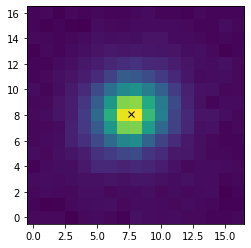

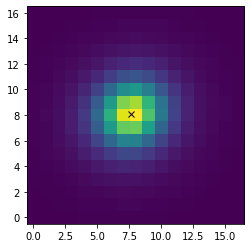

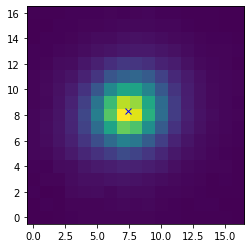

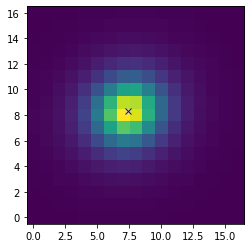

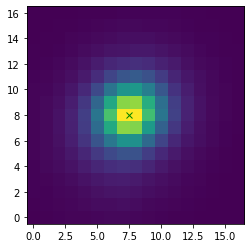

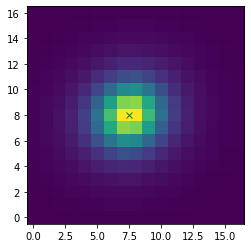

1.6406764
HE0040-1105
1.6406764
7 8
[0.37374781587702394, 7.646229920962274, 7.8129288177026455, 0.08414899914542179, 0.09509199392855588, 0.0002167134451121167, 2.6724289104081533, 3.2428403869251574, 3.447293742339448, -0.009900631634168457, 3.529264915175892, 3.751776654255912] [0.00188903 0.00502485 0.00544519 0.00149221 0.00171353 0.00080183
 0.02703732 0.02905948 0.03053846 0.03684468 0.01419669 0.01534246]
[0.63675247 8.17700415 7.67995385] [0.00264653 0.01036871 0.01030746]
[3.94090887 7.45491622 8.00512204] [0.00437692 0.00366337 0.0027684 ]


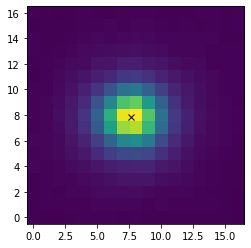

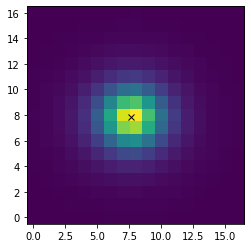

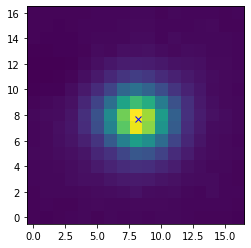

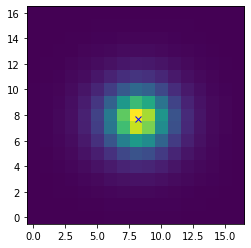

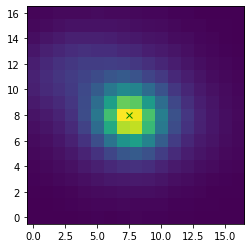

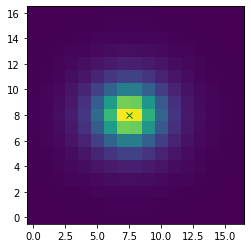

2.0286798
HE0108-4743
2.0286798
3 4
[1.2514618823731951, 4.05660063823958, 4.045133604961614, 0.09396877730795107, 0.09766001105767486, 0.008253175887986769, 2.429699625457328, 3.156995590568802, 3.309627850934063, -0.5751157853247192, 3.6278578343676076, 3.803255019969499] [0.04253371 0.02872784 0.03371411 0.01683009 0.01754387 0.00438913
 0.31359799 0.30255476 0.32828916 0.47769342 0.10226587 0.11692816]
[2.27472165 3.76312564 4.1385228 ] [0.03401964 0.03381499 0.0436837 ]
[6.74992411 3.18365504 4.13682781] [0.02142365 0.00942691 0.00854906]


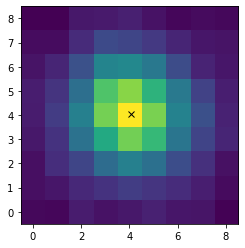

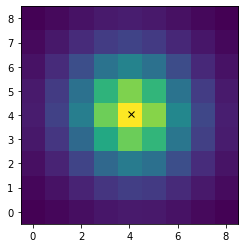

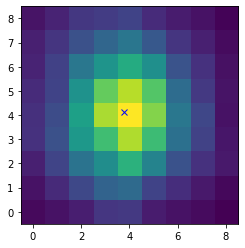

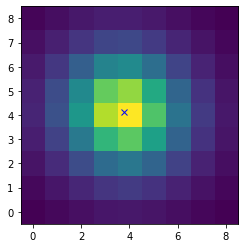

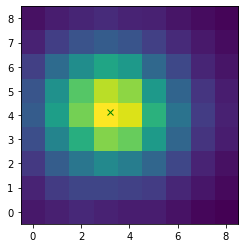

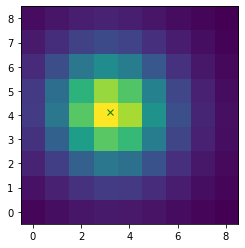

1.6333879
HE0114-0015
1.6333879
8 8
[0.12314883129236237, 7.652443087026326, 7.39568741667223, 0.09895044231922553, 0.11696741273613899, -0.015336323482335637, 3.140282157294733, 2.889291157430303, 3.225324322209471, 0.3525996346614436, 2.8718089069510313, 3.2058088339442103] [0.00378067 0.02293847 0.02372854 0.01124324 0.01344826 0.00464115
 0.23618786 0.16825154 0.19225849 0.08984923 0.05904882 0.07277133]
[0.07778913 7.79323936 8.1586755 ] [0.00375464 0.07138309 0.10647421]
[0.62154563 7.7141907  7.56483953] [0.00371706 0.0104871  0.01212773]


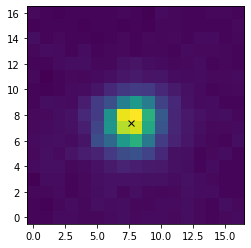

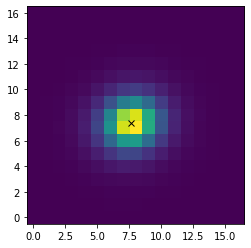

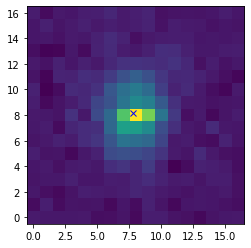

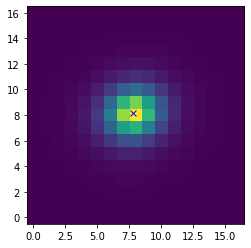

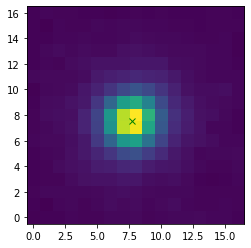

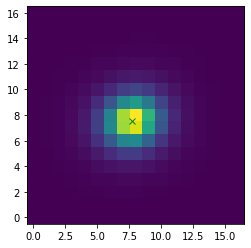

1.416731
HE0119-0118
1.416731
4 4
[1.683608859544853, 4.111707287988858, 4.057888882075726, 0.2999721461057558, 0.32283140067338295, 0.0021793838672075666, 2.47480157958439, 1.7598564999502198, 1.8259843700058762, -0.0475259685345678, 2.0010991064719095, 2.076291840473237] [0.0486039  0.01379548 0.01338318 0.02532426 0.02627027 0.00906666
 0.10171584 0.07062004 0.07553255 0.20739992 0.03686065 0.04165683]
[9.28788512 4.02910058 3.97910206] [0.0320598  0.00355262 0.00378942]
[13.82294726  4.09706942  3.97930291] [0.0418516  0.00291729 0.00306326]


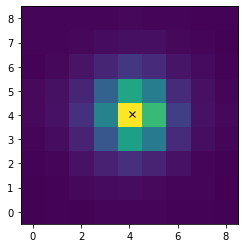

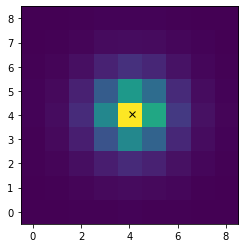

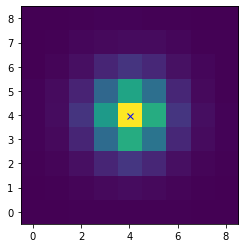

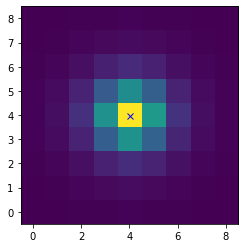

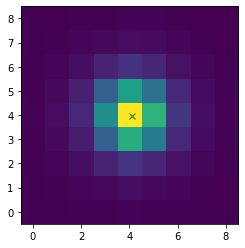

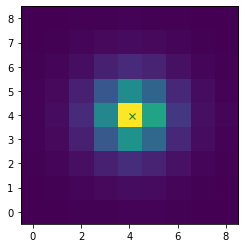

1.4458556
HE0212-0059
1.4458556
8 8


/home/mainak/anaconda2/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in power
  after removing the cwd from sys.path.


[0.28673174415923114, 8.271512984620149, 7.633289288559502, 0.14899345524216706, 0.14488454723836555, -0.0007677731757785897, 1.8007172274960634, 2.590386613338642, 2.6274972217164674, -0.09236276428493143, 3.549903785702729, 3.6007607074038415] [0.00678989 0.01746589 0.01917894 0.0064602  0.00603111 0.00235195
 0.02834764 0.05597547 0.05475118 0.34486471 0.04814814 0.04706209]
[0.24315656 8.45847118 8.96444602] [0.00456281 0.02178046 0.0580877 ]
[2.31831484 8.31962385 7.59869513] [0.00376751 0.00431055 0.00447209]


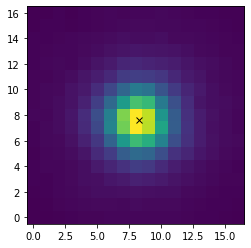

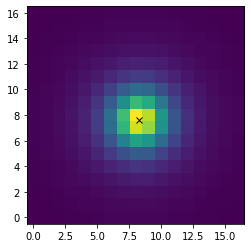

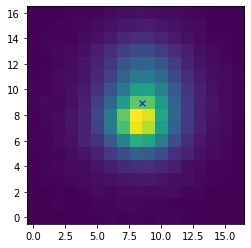

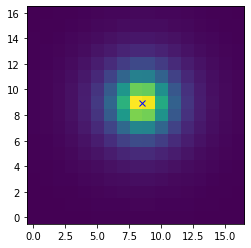

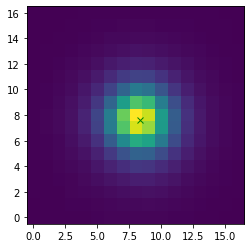

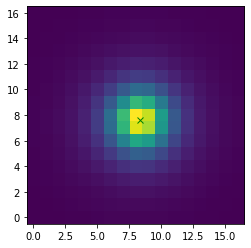

1.7209688
HE0224-2834
1.7209688
4 4
[0.3514043419747692, 3.884233785049928, 4.003868283707924, 0.05555152595803882, 0.05392477182864641, -0.0031536802662946012, 3.153458656259597, 4.206569618304628, 4.345203062050292, -0.5472836302318042, 4.171375303214393, 4.3088488685926585] [0.00241784 0.00697872 0.0075659  0.00284061 0.00283785 0.00049808
 0.11851683 0.10894188 0.11659488 0.14813786 0.02525983 0.0294349 ]
[0.98317412 3.93285257 3.93119001] [0.00539825 0.01483888 0.01274939]
[2.95961478 3.37039969 4.26629988] [0.00471728 0.00502231 0.00506926]


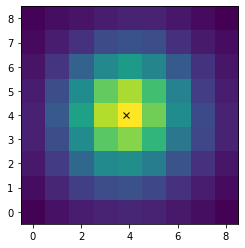

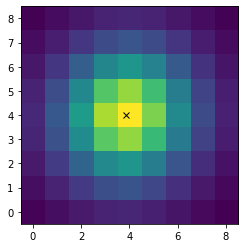

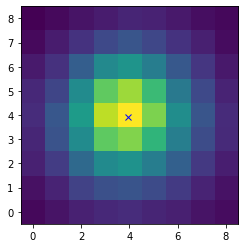

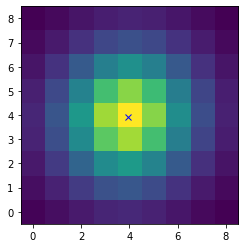

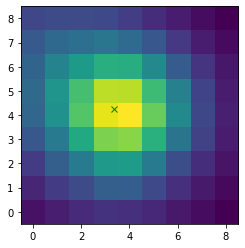

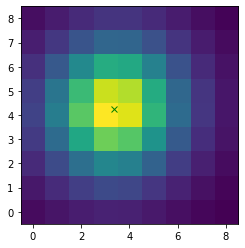

2.192149
HE0227-0913
2.192149
4 4
[7.204607413525162, 4.003452803070767, 4.0796452161663295, 0.11952720287349328, 0.11606094972803964, -0.0011512505290674252, 2.610932796578976, 2.8913293630004393, 2.9365079548035973, -0.1603340848787176, 3.188627160182695, 3.2384511915524254] [0.07963683 0.00589081 0.00618092 0.00540532 0.00534661 0.00104275
 0.06606107 0.06470608 0.0669037  0.14043979 0.02744005 0.0287085 ]
[0.62521198 4.08990369 4.1683315 ] [0.00607149 0.01757649 0.01921399]
[6.15619191 4.01811518 4.17152617] [0.00721023 0.00209934 0.00210613]


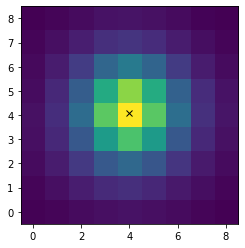

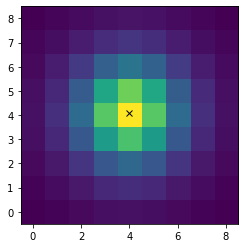

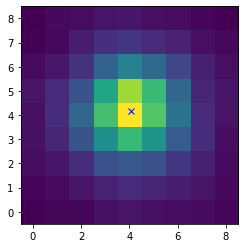

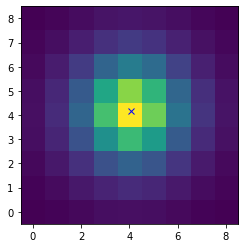

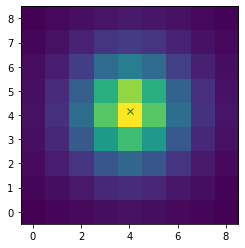

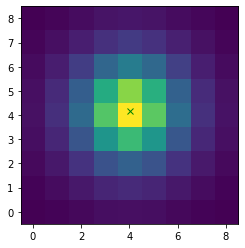

1.8799717
HE0232-0900
1.8799717
4 4
[7.780327180746303, 4.108291856167047, 4.111658134152973, 0.1327513088874375, 0.13055953659024871, 0.0009958733799168467, 2.576465687277347, 2.7434958048819986, 2.7686948960399222, 0.2132406205194629, 3.048589102730304, 3.076590484968998] [0.07112615 0.00391754 0.00405101 0.00282813 0.00277968 0.0005848
 0.02681988 0.02918139 0.02950852 0.13193872 0.01571756 0.01617765]
[20.55805743  3.74395605  3.96996092] [0.22021918 0.01916824 0.02090206]
[49.94470099  4.0504125   3.34547747] [0.07968376 0.00200931 0.00368183]


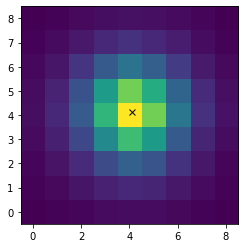

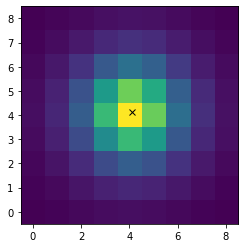

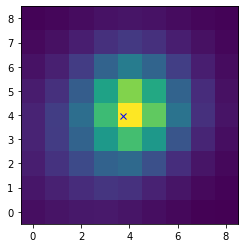

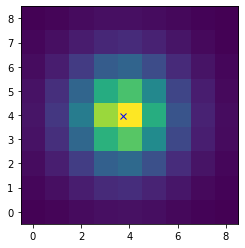

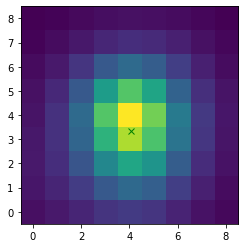

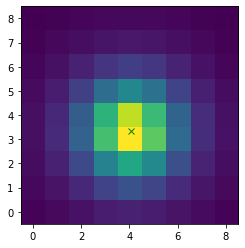

1.6392349
HE0253-1641
1.6392349
4 4
[2.7465671244097463, 4.07464893468126, 3.7742012959671283, 0.16902250923298276, 0.15380968744793913, 0.009845981383833, 2.962187055156193, 2.4219633550362487, 2.5619511445677765, 0.2872077997385085, 2.48716903493896, 2.630925667205247] [0.05679826 0.00975642 0.01227658 0.01113302 0.01026326 0.00298978
 0.11362875 0.08020563 0.08861832 0.08678518 0.03318197 0.0384387 ]
[6.93289729 4.01385898 3.80010016] [0.01378331 0.0027005  0.00237592]
[21.99043855  3.9493375   3.54178553] [0.02648431 0.00202833 0.00176231]


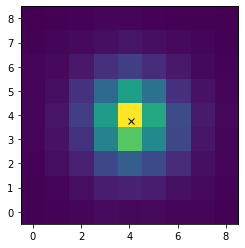

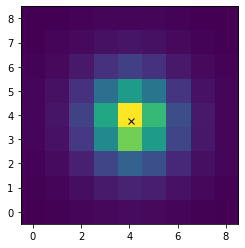

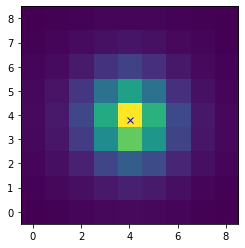

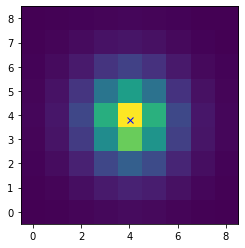

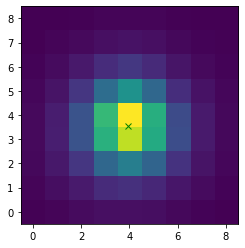

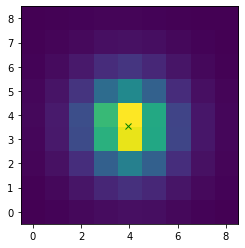

1.6350082
HE0345+0056
1.6350082
4 4
[29.23988125943543, 4.099465333038694, 4.0632655488495875, 0.20314693002736361, 0.19121063443226471, 0.005006814584330118, 2.597785996460122, 2.215935100546279, 2.2899017416442993, 0.19858500890551736, 2.450821642453497, 2.5326286614306905] [0.28962889 0.00441635 0.00386711 0.00398472 0.00365752 0.00109288
 0.02380435 0.02165839 0.02175528 0.04359825 0.01267467 0.0121938 ]
[11.80085321  4.1083368   4.00839377] [0.02640729 0.00269316 0.00283253]
[21.6933336   4.09479561  3.95564615] [0.03144518 0.00248629 0.00257884]


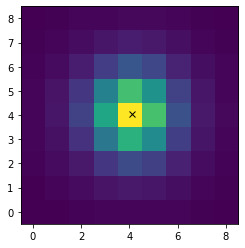

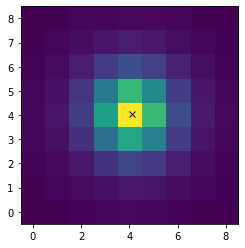

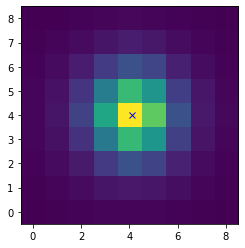

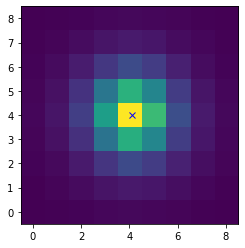

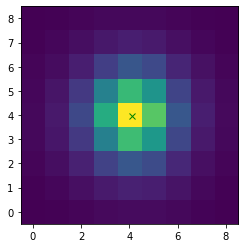

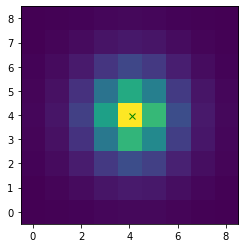

1.4870944
HE0351+0240
1.4870944
4 4
[3.744130285792111, 3.9391041288994586, 3.7191173215686164, 0.22397134131332483, 0.19810528658529308, -0.003929521952720848, 3.087427517348021, 2.1123211783779845, 2.2475775307662755, -0.07538265627520403, 2.119510688020744, 2.2552273997803725] [0.02045933 0.00345223 0.00392844 0.00599877 0.0052629  0.00181134
 0.05289182 0.02838553 0.02995878 0.03334568 0.00960014 0.01057593]
[2.31539586 3.9087918  3.71809919] [0.03750493 0.02595971 0.0267279 ]
[43.45786542  3.96374281  3.7006755 ] [0.04634563 0.00119925 0.00133903]


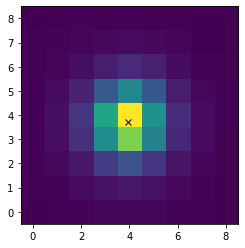

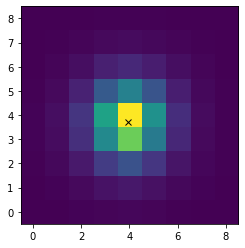

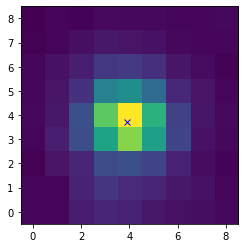

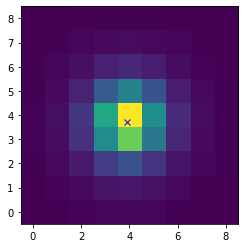

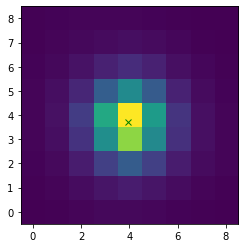

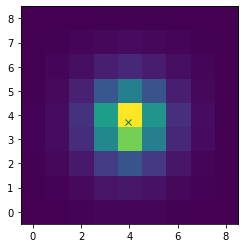

1.4179466
HE0412-0803
1.4179466
8 8
[1.6358603255072284, 7.959856875968581, 7.960754358439762, 0.08607057015636056, 0.08940639836281107, 0.010054420972175787, 2.423894718205052, 3.2785094787482905, 3.4827816456320098, -0.6252234473268558, 3.772678963665544, 4.007741058760908] [0.00407934 0.00221447 0.00245801 0.00057667 0.00060932 0.0001984
 0.007667   0.01087568 0.01199818 0.00932865 0.00624434 0.00735048]
[5.56436    8.16199575 7.96275074] [0.01940799 0.00936217 0.01077407]
[53.60901786  8.37854038  8.04265107] [0.02279895 0.00154663 0.00203731]


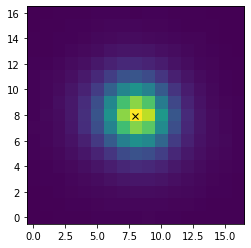

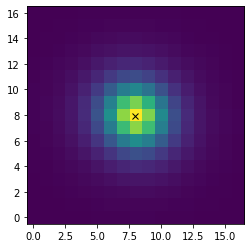

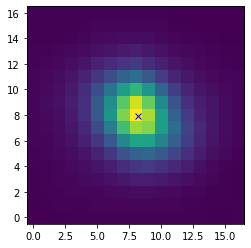

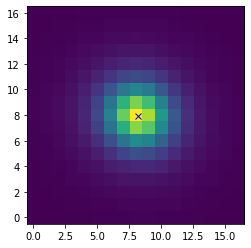

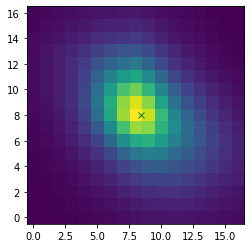

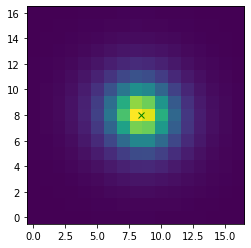

1.2614789
HE0429-0247
1.2614789
4 4
[1.8364964123644363, 4.078518100095908, 3.82487324718341, 0.17182923338793737, 0.1618136826386613, -0.002761996727184654, 2.6587463422651822, 2.4111008195448767, 2.48738709743847, -0.13454135131241882, 2.6317212063113384, 2.7149878261290143] [0.03336605 0.00887839 0.00788166 0.01015035 0.00943022 0.00239922
 0.08599584 0.07155514 0.07332015 0.11506826 0.0327775  0.03402593]
[2.15166287 4.19761261 3.78866569] [0.01129983 0.00809067 0.00839497]
[10.61509128  3.85072315  3.86827914] [0.01598574 0.0024434  0.00209818]


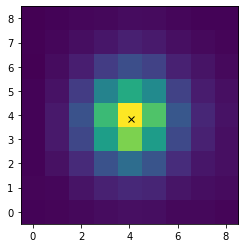

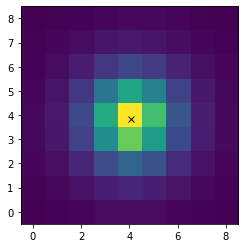

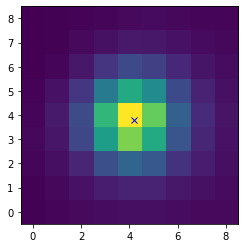

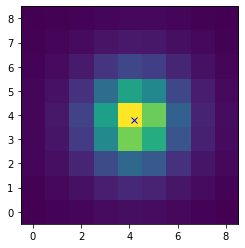

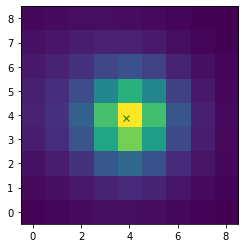

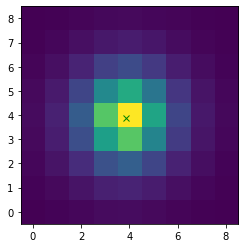

1.2710024
HE0433-1028
1.2710024
8 8
[2.637918942336923, 7.791670815512187, 8.126958120859198, 0.14496520574228813, 0.1452323553765629, -0.0015342089991835267, 2.250774880713513, 2.618218887609358, 2.632307003931495, 0.6991981555770506, 3.1446789746913204, 3.16159986828081] [0.01940911 0.00580467 0.00584901 0.00252194 0.00245696 0.00094497
 0.0160701  0.02272568 0.02231374 0.57194095 0.0154228  0.01493513]
[5.28819952 7.88844766 8.03085007] [0.00663551 0.00273486 0.00269089]
[5.27408258 7.83933408 8.21846481] [0.01041618 0.00367065 0.00358596]


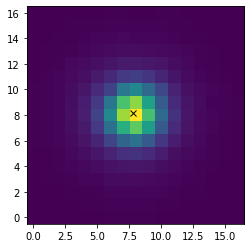

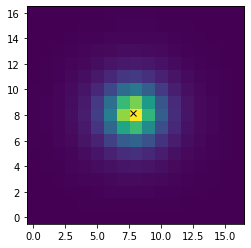

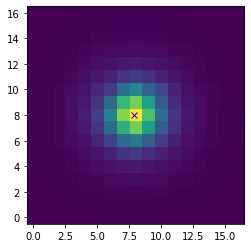

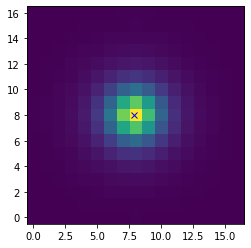

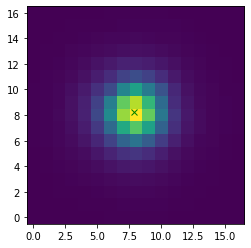

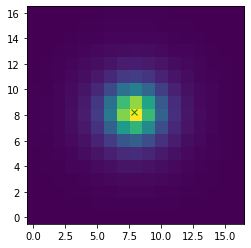

1.4730742
HE0853+0102
1.4730742
8 8
[0.18864548149593444, 7.944609249176026, 8.315234421834724, 0.11781000333142429, 0.10834572100205964, -0.010684600513810668, 3.3212141366600565, 2.8841733096047424, 3.07232924574747, -0.42294466344444115, 2.7788763770049125, 2.960163016195095] [0.00244398 0.00889952 0.00977619 0.00679884 0.00637976 0.00206336
 0.12407059 0.08344384 0.09017371 0.07288741 0.02784934 0.03081788]
[0.32453219 7.98658989 8.25439391] [0.00236063 0.01198007 0.0121808 ]
[1.13366349 8.15910002 8.48830466] [0.00307468 0.00390857 0.00481426]


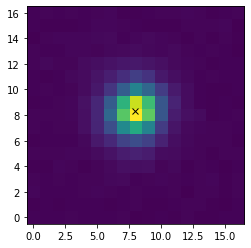

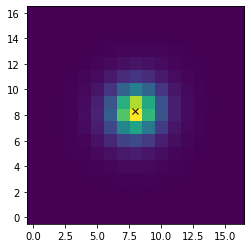

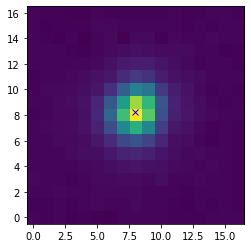

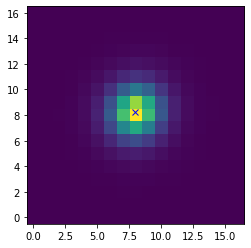

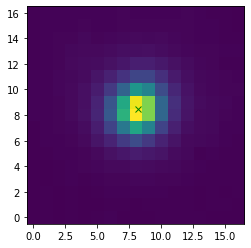

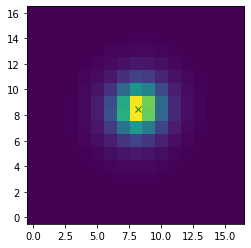

2.2774768
HE0934+0119
2.2774768
8 8
[0.9219528966058941, 7.535174684403432, 7.5606872496157775, 0.1006902187852692, 0.10172382704752812, -0.0006269201837619058, 2.2636751757821503, 3.134019310681957, 3.1527927801833244, 0.2726056093312565, 3.7517226464133393, 3.7741962956470783] [0.01409194 0.01123526 0.01268247 0.00444406 0.00450368 0.00133968
 0.04620674 0.06913998 0.06971908 0.41398909 0.04138298 0.04158238]
[0.99935932 7.62757399 7.42907073] [0.00457414 0.00905049 0.00898451]
[2.22317481 7.43467774 7.61546902] [0.00387171 0.00410929 0.00440239]


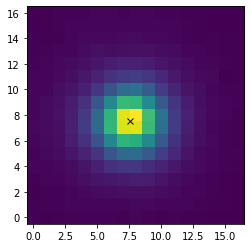

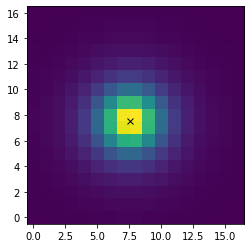

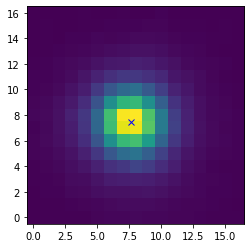

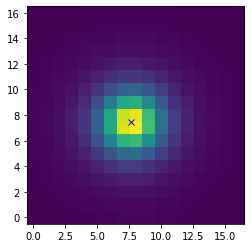

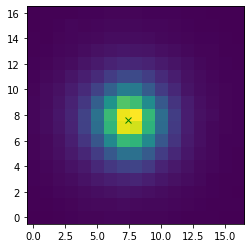

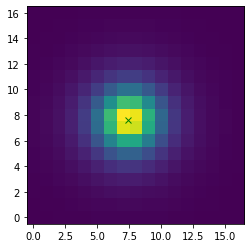

1.6947104
HE1011-0403
1.6947104
8 8
[0.8174712024764184, 7.7790398444316375, 7.846404678423024, 0.0681399558999087, 0.06711903872148281, -0.0009654400144011977, 2.598983568737403, 3.8254960754768805, 3.865445150218074, -0.3787381621139394, 4.229883516946064, 4.274055548345666] [0.00822112 0.01061654 0.01179842 0.00220007 0.00208644 0.00076414
 0.04399015 0.06080309 0.06012709 0.31140901 0.03075988 0.02979332]
[0.55052838 7.85478083 7.82955596] [0.00229903 0.00963259 0.01065681]
[1.23389747 7.74782445 7.78958305] [0.00276671 0.00543001 0.00586603]


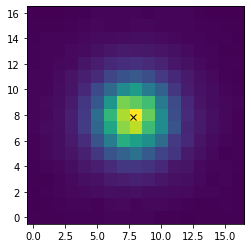

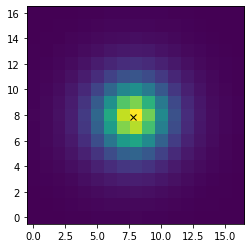

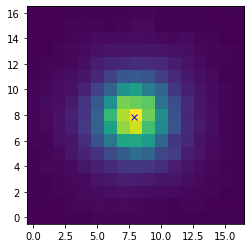

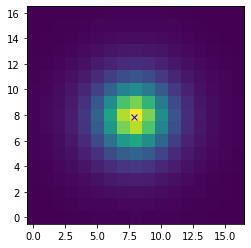

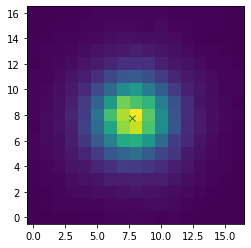

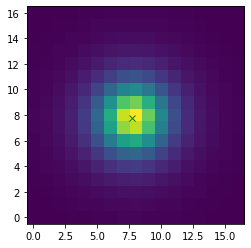

1.5494856
HE1017-0305
1.5494856
8 8
[0.6895854795816886, 8.15318274792975, 7.986132790802969, 0.07503217943195664, 0.08221943011397378, 0.001958987878955724, 2.6678898056967246, 3.484711351644157, 3.653894057292905, -0.1330501717684152, 3.796160932309687, 3.9804645123761406] [0.00484054 0.00673915 0.00594619 0.0017863  0.00194031 0.00052805
 0.03386372 0.04088959 0.04345375 0.03467544 0.01912262 0.02128015]
[0.54253621 8.20369005 7.82588247] [0.00424686 0.01902669 0.01966721]
[1.38866763 8.10207192 8.05464387] [0.00671087 0.01086759 0.01087432]


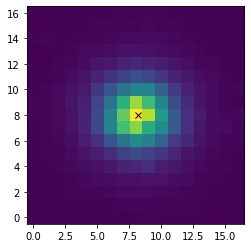

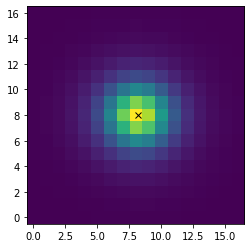

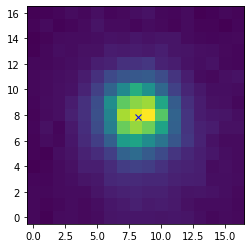

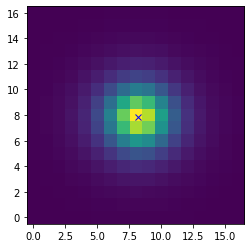

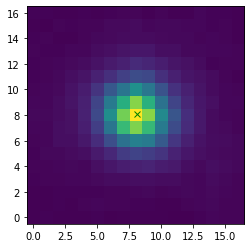

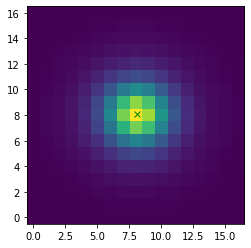

1.6829182
HE1029-1831
1.6829182
8 8
[0.38081978984073006, 7.882128163966215, 8.219218271736034, 0.08936967655648527, 0.09541447210681357, 0.004222941505890805, 2.4433731647668897, 3.2261594744600632, 3.3575733697487626, -0.3048955056461675, 3.6954043553164118, 3.8459324010759075] [0.00786108 0.01988072 0.02130025 0.00643245 0.00708944 0.00192242
 0.09489969 0.11954068 0.12308837 0.14331668 0.06133913 0.0633881 ]
[1.64503192 7.6317349  8.49720918] [0.00656119 0.01054452 0.01252079]
[0.42814858 8.34519031 8.08859235] [0.0057855  0.02011181 0.02443137]


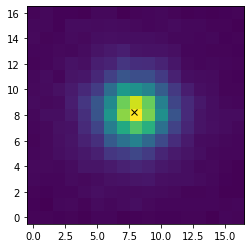

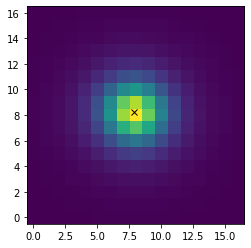

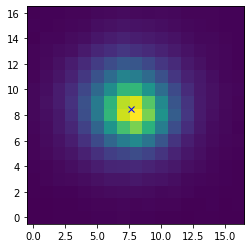

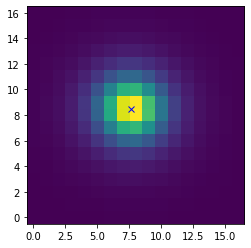

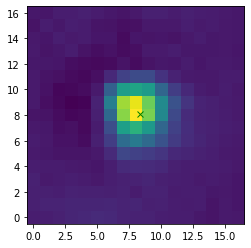

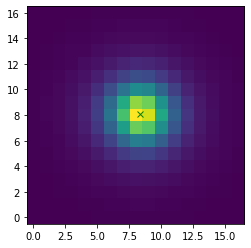

1.3308307
HE1107-0813
1.3308307
8 8
[0.9238765656277096, 7.862814210018175, 7.927539388721893, 0.10131497959129007, 0.10254171217612952, -0.011259947218102452, 2.5642628469463276, 3.048672339166124, 3.223039736189116, 0.7311388792408594, 3.396890106642133, 3.5911736569794415] [0.01611759 0.01238071 0.01061528 0.00389613 0.00379196 0.00126741
 0.04127537 0.05788281 0.05969548 0.61964619 0.03578306 0.03571426]
[0.13743918 7.98776702 7.98276111] [0.00283802 0.04254647 0.04128972]
[0.46993097 7.13038592 7.59344264] [0.00494372 0.03050837 0.01665815]


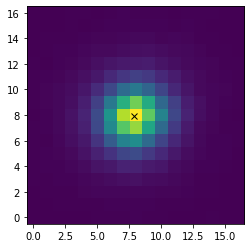

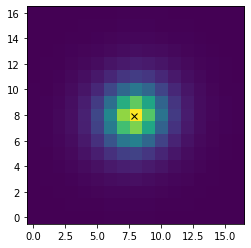

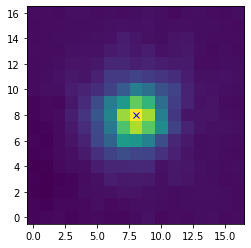

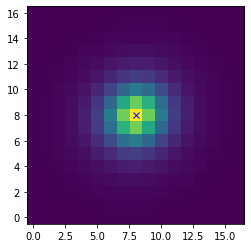

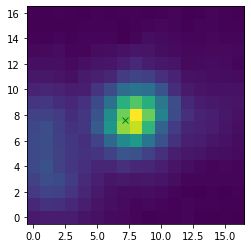

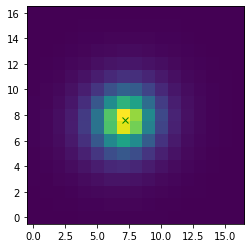

1.809293
HE1108-2813
1.809293
8 8
[1.6126748887608395, 7.902372847099154, 8.452981453543913, 0.20459976289354256, 0.2039623066591782, 0.013516982218191975, 2.5244101616440044, 2.176759106961694, 2.250090173097766, 0.7618357927776215, 2.4471847831535674, 2.5296259998259556] [0.01314992 0.00484989 0.00511898 0.00509638 0.00510677 0.00182162
 0.03201565 0.02711325 0.02801477 0.70301646 0.01437755 0.01472158]
[2.11540497 8.17257599 8.47615248] [0.01168787 0.00769734 0.0095499 ]
[4.64667852 8.19271669 8.39876547] [0.01402204 0.00495067 0.00553026]


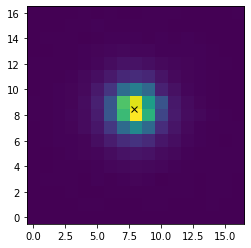

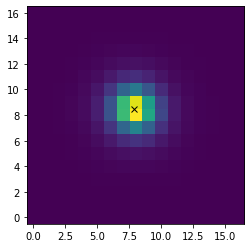

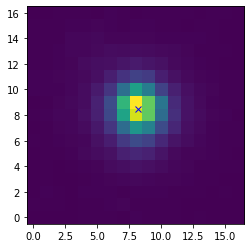

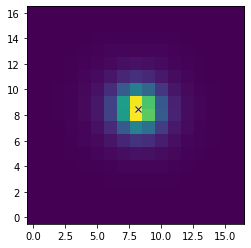

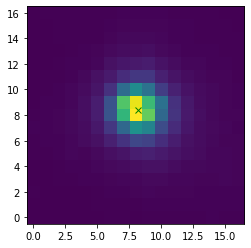

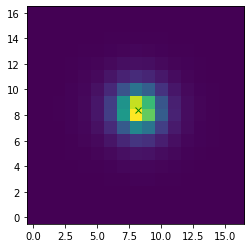

1.7090701
HE1126-0407
1.7090701
4 4
[10.625733498379933, 3.859256904951469, 4.099803424963187, 0.2565049196544535, 0.25047514073461496, -0.012906010501407267, 2.718543030493042, 1.9588550708324624, 2.0146903970973713, -0.5668627622490646, 2.111289700635303, 2.1714700330294785] [0.19460328 0.00720526 0.00701732 0.00886291 0.00846407 0.00254658
 0.04203851 0.0336233  0.03505947 0.20801393 0.01943613 0.02045081]
[2.84438967 3.92012322 4.08816949] [0.0256959  0.01016261 0.01068583]
[19.69416632  4.02507277  4.42084129] [0.03596962 0.00222529 0.0026435 ]


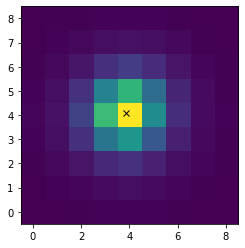

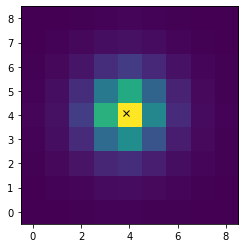

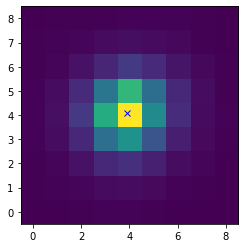

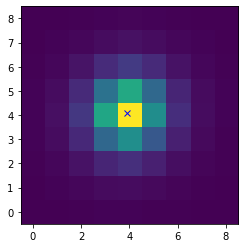

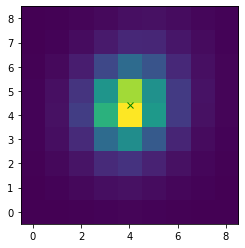

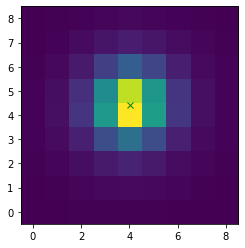

2.2745798
HE1237-0504
2.2745798
8 8
[2.5980297870275333, 7.587384645981177, 8.269371252355418, 0.15469220292475927, 0.158717787356676, 0.008397096704776305, 2.3312523914056333, 2.489433915062382, 2.5645333211667944, -0.5618812682080447, 2.929745925340973, 3.01812833939048] [0.00560105 0.00150652 0.00149095 0.00091676 0.00091798 0.00031507
 0.00638375 0.00712462 0.00767366 0.01836674 0.00425946 0.00482911]
[2.03710207 7.41816797 8.24042244] [0.00478267 0.00433672 0.00477543]
[15.64860835  8.00117841  8.34688991] [0.00600996 0.00081526 0.00075886]


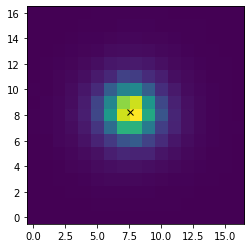

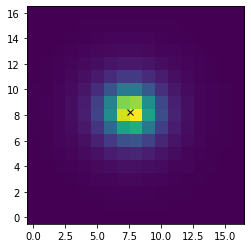

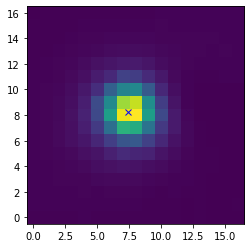

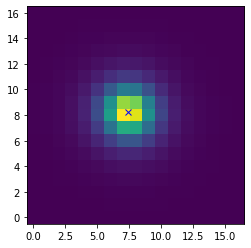

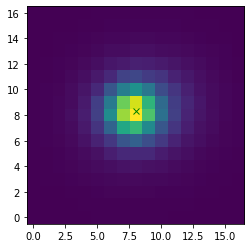

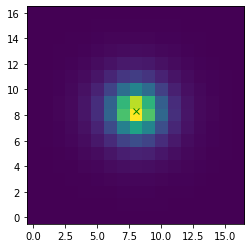

1.7084275
HE1248-1356
1.7084275
8 8
[0.16661538074371468, 8.258421403369425, 7.631165000326486, 0.07873390721706323, 0.07379595766606815, -0.00401420652921746, 4.161286160661988, 3.5478217132921825, 3.6990621887181985, -0.34128770733951913, 3.0208339643976507, 3.149609422095215] [0.00288099 0.01619228 0.01881011 0.01006038 0.01026308 0.00250189
 0.42027015 0.23295276 0.25934738 0.23582867 0.04384234 0.06102344]
[0.62843584 8.37582377 7.52997429] [0.00473969 0.02036127 0.01836571]
[4.68647109 8.5821678  7.58434059] [0.00800966 0.00348949 0.00330455]


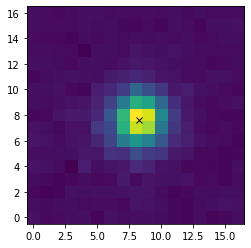

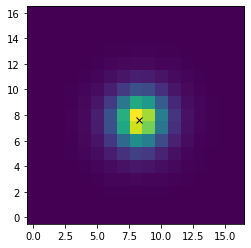

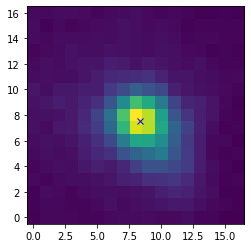

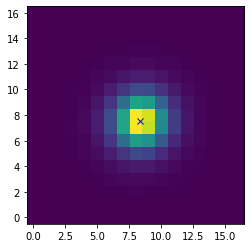

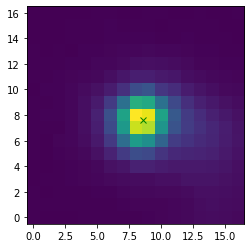

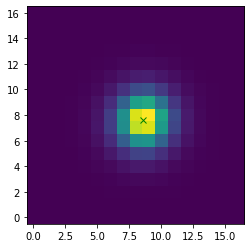

1.5501313
HE1330-1013
1.5501313
8 8
[0.3130593779293266, 7.64824214849236, 7.8366024250220825, 0.0947704063320216, 0.0929079729973245, 0.0018101418227697184, 2.421477574551502, 3.242078380584971, 3.28725828711938, 0.38558037392491284, 3.7328972502065945, 3.7849169514811996] [0.00711889 0.02075672 0.02287519 0.00676104 0.00693677 0.00253307
 0.08912774 0.11417515 0.12233141 0.44653704 0.06151582 0.06944847]
[0.15056747 7.48573673 8.05096274] [0.0025122  0.02951787 0.0432609 ]
[0.73577321 7.81516251 7.62658792] [0.00328274 0.01234911 0.01082805]


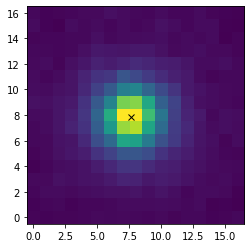

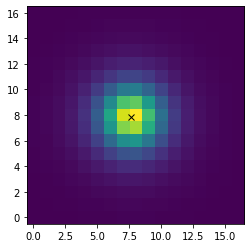

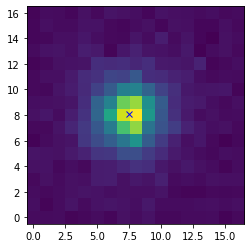

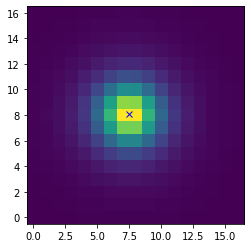

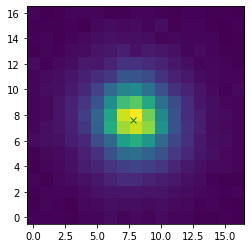

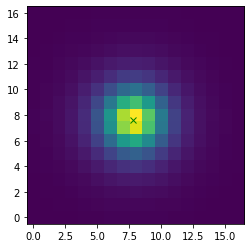

1.5308046
HE1353-1917
1.5308046
8 9
[0.1280984877600481, 8.472748670986439, 7.5337824118974, 0.07136972339651033, 0.0754550774361739, 0.0009262240117999932, 2.6778868589115183, 3.6392059115890167, 3.744559861085135, -0.11147461149242634, 3.956055828658322, 4.070582490820812] [0.00177591 0.01955347 0.0174967  0.00457736 0.00441752 0.00145935
 0.09322525 0.10547108 0.11758133 0.22360139 0.04542929 0.05523752]
[ 0.16358216 11.44102383  3.22113758] [0.00156094 0.03437638 0.0392132 ]
[1.54264885 8.36566119 9.06692933] [0.00345465 0.00906426 0.01379456]


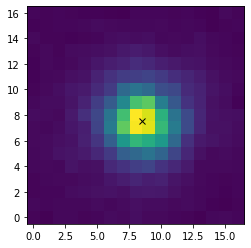

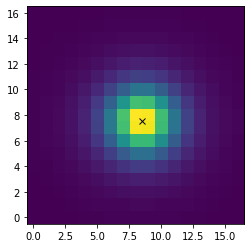

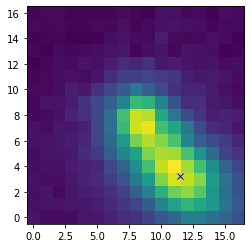

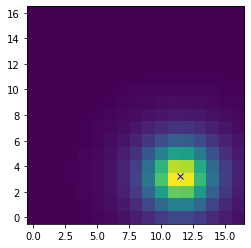

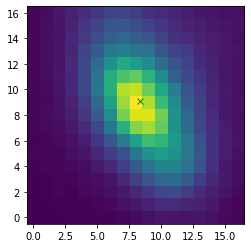

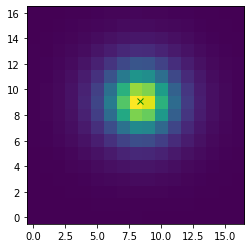

1.4628958
HE1417-0909
1.4628958
4 4
[1.642728089215346, 4.202479012714359, 4.159700083073691, 0.2894932971048163, 0.27003591458443077, 0.021157956144566396, 2.6248269185680533, 1.8438486118263924, 1.9411353268665914, 0.41362197630322173, 2.027307586235035, 2.134274120350609] [0.01030116 0.00329257 0.00332213 0.00565636 0.00519162 0.00189958
 0.02697091 0.01822928 0.01853856 0.02841821 0.00918804 0.00917798]
[3.02706881 4.29823387 4.10558853] [0.022915   0.00899116 0.00796269]
[14.99803844  4.21603543  4.17844247] [0.02785209 0.0022604  0.00207853]


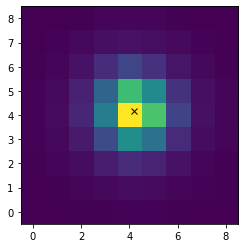

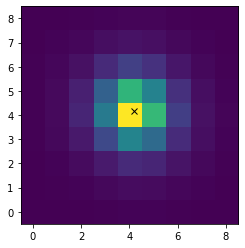

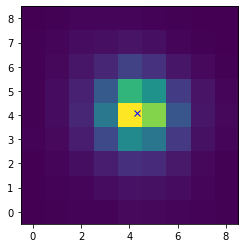

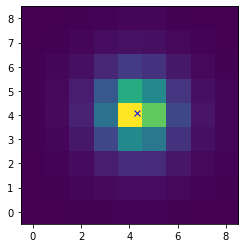

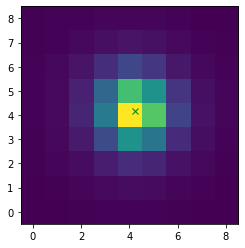

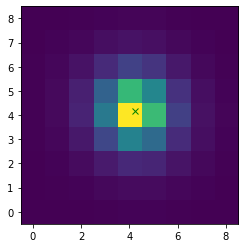

1.602829
HE2128-0221
1.602829
8 8
[0.24674607558574665, 7.6620516177209, 7.473572188845864, 0.07340467022553085, 0.0720066108139869, 0.0011109386305505654, 2.8861667318285598, 3.6860865973694135, 3.731634600769099, 0.3357286926822887, 3.8410008289782387, 3.888463066827276] [0.00187587 0.00882795 0.00836203 0.00253568 0.00263193 0.00077592
 0.0612758  0.06381975 0.06643243 0.2642214  0.02388168 0.02570653]
[0.42871402 7.68097254 7.62063648] [0.00365692 0.01934462 0.01886594]
[1.7437469  7.70678187 7.72126456] [0.00368073 0.00527797 0.00626997]


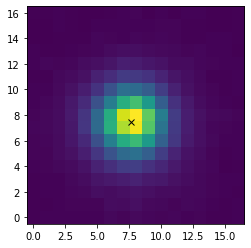

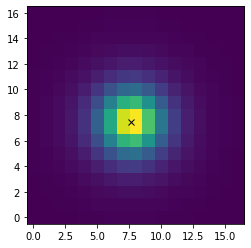

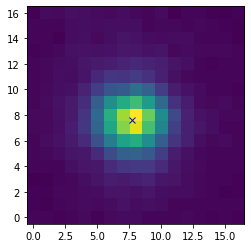

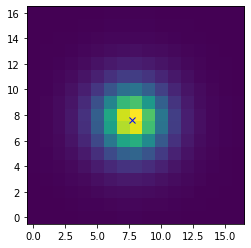

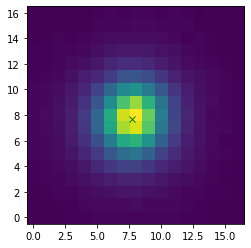

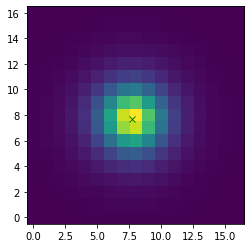

1.8953648
HE2211-3903
1.8953648
8 8
[0.3849172616302686, 8.363392928237788, 7.830597070510835, 0.14711072580724227, 0.13545893306573262, -0.008000139657961439, 2.8890543971354425, 2.5962926035637484, 2.7295735163562673, -0.30083852152774526, 2.703885191881914, 2.8426893798095514] [0.00341148 0.00524109 0.00619678 0.00474592 0.00427839 0.00153145
 0.05240699 0.04149139 0.04230488 0.04924441 0.01889941 0.01787237]
[0.14675638 8.53306074 8.07916598] [0.00277396 0.03930841 0.0362423 ]
[3.68058347 8.34785919 8.04502153] [0.00443308 0.002625   0.00211172]


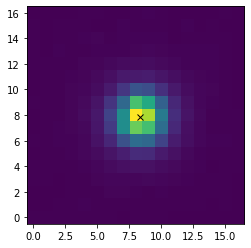

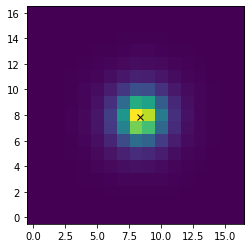

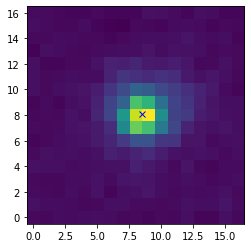

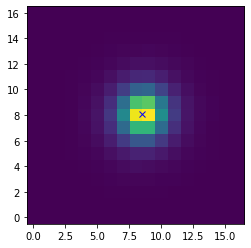

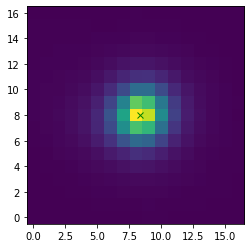

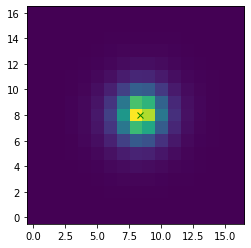

1.6834092
HE2222-0026
1.6834092
8 8
[0.18127241091939456, 7.855895759472871, 7.93124983711838, 0.09389473116700406, 0.0989357290346131, -0.00424030505478015, 2.5629294389659365, 3.166891151311698, 3.276987403635645, 0.34967089484175207, 3.529659281309725, 3.6523670853628203] [0.00316597 0.01161267 0.01055139 0.00467517 0.00495283 0.00154225
 0.06698682 0.07925794 0.08410598 0.11300969 0.04122099 0.04425696]
[0.08208631 8.0240532  7.98969433] [0.00158183 0.0421448  0.03987924]
[0.43950048 7.82226519 7.96465151] [0.00170455 0.00731608 0.00617291]


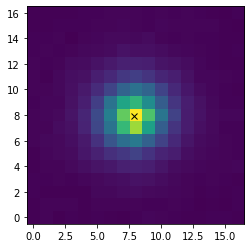

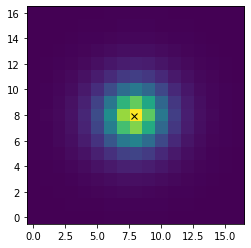

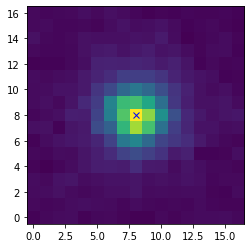

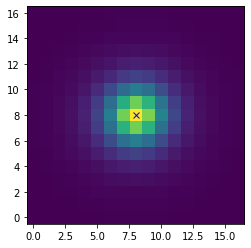

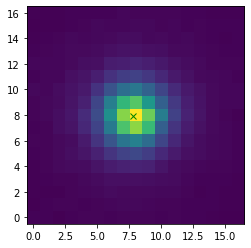

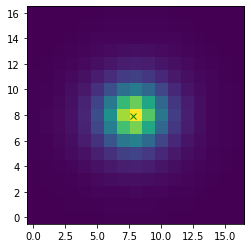

1.4602867
HE2233+0124
1.4602867
4 4
[0.2242987267283856, 3.971783603642893, 3.987171185765113, 0.17068590684393758, 0.1614860861194595, -0.02308896683149167, 3.1944322914337913, 2.3668181279741862, 2.5510632587543687, -0.5958130260752398, 2.3302126651523145, 2.511608240994088] [0.00750239 0.01709989 0.01886756 0.02101924 0.01917238 0.00585035
 0.25612443 0.14464723 0.1595353  0.35205799 0.05080535 0.05629763]
[0.1358181  3.99736452 3.99550945] [0.00518089 0.04719948 0.0573969 ]
[1.04748322 3.87152302 3.98834265] [0.00622026 0.00845879 0.00941412]


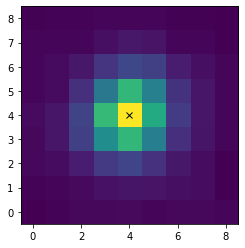

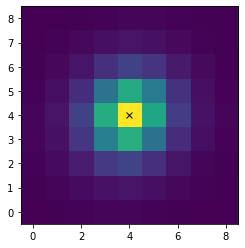

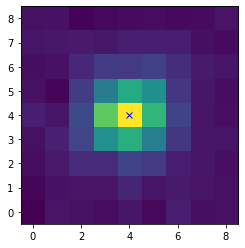

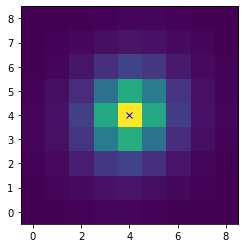

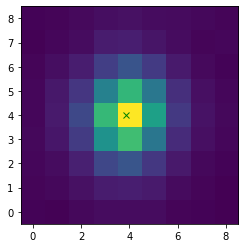

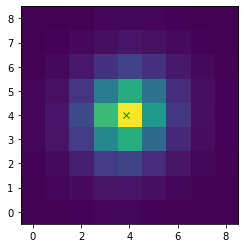

2.0455244
HE2302-0857
2.0455244
8 8
[1.395150749670013, 7.968606611576678, 7.803874389631776, 0.10381841561653735, 0.10122804483741746, 0.003350841678408855, 2.439946292346898, 3.091357696441521, 3.155884680848707, 0.4563525969798328, 3.5438510828055243, 3.617823119048632] [0.02798263 0.01055589 0.01068154 0.00376887 0.00359236 0.00089969
 0.03426836 0.05362919 0.05669991 0.16774227 0.03569421 0.03828949]
[1.23005805 8.34511863 7.87423211] [0.01035504 0.01546743 0.01441061]
[14.40056263  7.19214858  7.58854361] [0.01303528 0.00263258 0.00191465]


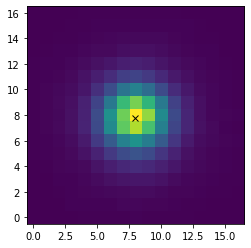

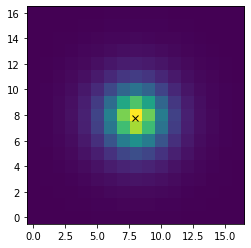

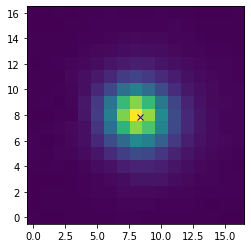

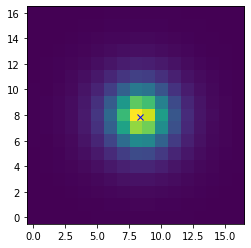

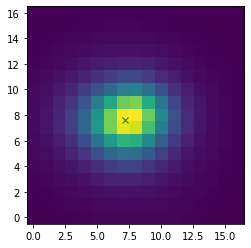

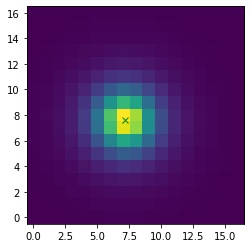

In [9]:
z = {"HE0021-1819":0.053197,"HE0040-1105":0.041692,"HE0108-4743":0.02392,"HE0114-0015":0.04560
    ,"HE0119-0118":0.054341,"HE0212-0059":0.026385,"HE0224-2834":0.059800,"HE0227-0913":0.016451,"HE0232-0900":0.043143
    ,"HE0253-1641":0.031588,"HE0345+0056":0.031,"HE0351+0240":0.036,"HE0412-0803":0.038160,"HE0429-0247":0.042009
    ,"HE0433-1028":0.035550,"HE0853+0102":0.052,"HE0934+0119":0.050338,"HE1011-0403":0.058314,"HE1017-0305":0.049986
    ,"HE1029-1831":0.040261,"HE1107-0813":0.058,"HE1108-2813":0.024013,"HE1126-0407":0.061960,"HE1237-0504":0.009
    ,"HE1248-1356":0.01465,"HE1330-1013":0.022145,"HE1353-1917":0.035021,"HE1417-0909":0.044,"HE2128-0221":0.05248
    ,"HE2211-3903":0.039714,"HE2222-0026":0.059114,"HE2233+0124":0.056482,"HE2302-0857":0.046860}


objs = z.keys()

for obj in objs:
    (Hb_blr_br_data,OIII_br_data,OIII_nr_data,amp_Hb_blr_br,amp_OIII_br,amp_OIII_nr,Hb_blr_br_err,OIII_br_err,OIII_nr_err) = flux_data_err(obj)
    box_size = np.shape(Hb_blr_br_data)[1]  
    y, x = np.mgrid[:box_size, :box_size]
    xy=(x,y)
    algorithm_script(obj,z[obj])